In [1]:
import openmc
import numpy as np
import tokamak_radiation_environment as tre

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker

In [2]:
efus = 17.6e6  # eV
ev2j = 1.60218e-19
Pfus = 500e6  # W

neutron_rate = Pfus / efus / ev2j  # n/s

iter_meshvol = 1.6e4  # cm3
arc_meshvol = 4.48e3  # cm3

In [3]:
iter_sp = openmc.StatePoint("../reactors/iter_class/example_statepoint.100.h5")
arc_sp = openmc.StatePoint("../reactors/arc_class/example_statepoint.030.h5")

In [4]:
iter_tfcoil_spectrum = iter_sp.get_tally(id=4)
arc_tfcoil_spectrum = arc_sp.get_tally(id=4)

iter_spectrum_mean = iter_tfcoil_spectrum.mean[:,0,0]
arc_spectrum_mean = arc_tfcoil_spectrum.mean[:,0,0]

iter_spectrum_stddev = iter_tfcoil_spectrum.std_dev[:,0,0]
arc_spectrum_stddev = arc_tfcoil_spectrum.std_dev[:,0,0]

ebins = iter_tfcoil_spectrum.filters[2].bins[:,0]

[]

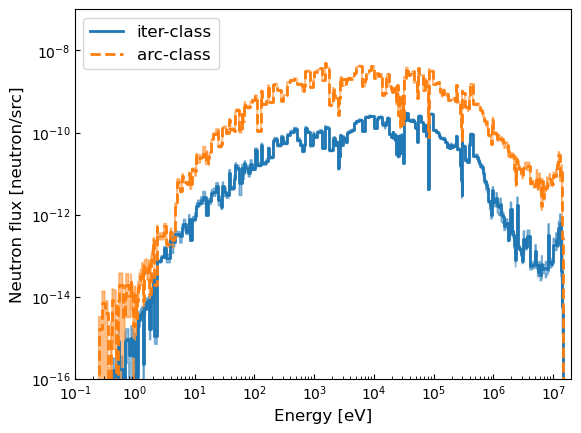

In [5]:
fig, ax = plt.subplots()
ax.fill_between(ebins, (iter_spectrum_mean - iter_spectrum_stddev)/iter_meshvol, (iter_spectrum_mean + iter_spectrum_stddev)/iter_meshvol, step='pre', color='tab:blue', alpha=.5)
ax.plot(ebins, iter_spectrum_mean/iter_meshvol, lw=2, ls='-', c='tab:blue', drawstyle='steps-pre', label='iter-class')
ax.fill_between(ebins, (arc_spectrum_mean - arc_spectrum_stddev)/arc_meshvol, (arc_spectrum_mean + arc_spectrum_stddev)/arc_meshvol, step='pre', color='tab:orange', alpha=.5)
ax.plot(ebins, arc_spectrum_mean/arc_meshvol, lw=2, ls='--', c='tab:orange', drawstyle='steps-pre', label='arc-class')
ax.set_xlim(1e-1, 2e7), ax.set_ylim(1e-16, 1e-7)
ax.set_xscale('log'), ax.set_yscale('log')
ax.legend(loc='upper left', fontsize=12)
ax.tick_params(axis='both', which='both', direction='in')
ax.set_xlabel('Energy [eV]', fontsize=12)
ax.set_ylabel('Neutron flux [neutron/src]', fontsize=12)
# plt.savefig('spectra_compared.png', dpi=600)
plt.plot()

/tmp/ipykernel_5875/1006810897.py:1: RuntimeWarning: invalid value encountered in divide
  plt.loglog(ebins, iter_tfcoil_spectrum.std_dev[:,0,0] / iter_tfcoil_spectrum.mean[:,0,0])
/tmp/ipykernel_5875/1006810897.py:2: RuntimeWarning: invalid value encountered in divide
  plt.loglog(ebins, arc_tfcoil_spectrum.std_dev[:,0,0] / arc_tfcoil_spectrum.mean[:,0,0])


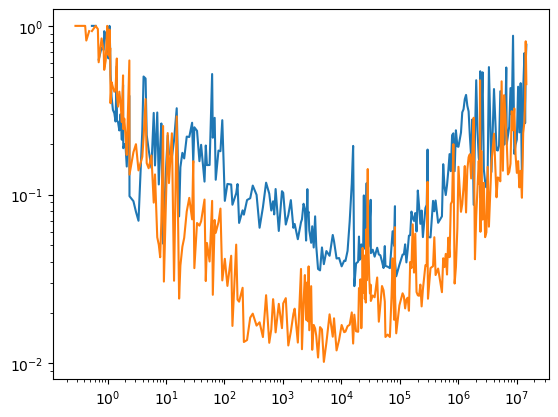

In [6]:
plt.loglog(ebins, iter_tfcoil_spectrum.std_dev[:,0,0] / iter_tfcoil_spectrum.mean[:,0,0])
plt.loglog(ebins, arc_tfcoil_spectrum.std_dev[:,0,0] / arc_tfcoil_spectrum.mean[:,0,0])

In [7]:
# total values
iter_flux = sum(iter_spectrum_mean) * neutron_rate / iter_meshvol
arc_flux = sum(arc_spectrum_mean) * neutron_rate / arc_meshvol
iter_stddev = sum(iter_spectrum_stddev) * neutron_rate / iter_meshvol
arc_stddev = sum(arc_spectrum_stddev) * neutron_rate / arc_meshvol

print("{:e}".format(iter_flux), "{:e}".format(iter_stddev))
print("{:e}".format(arc_flux), "{:e}".format(arc_stddev))

2.329614e+12 1.437912e+11
3.696664e+13 8.756263e+11


/tmp/ipykernel_5875/189783337.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x, fontsize=11)


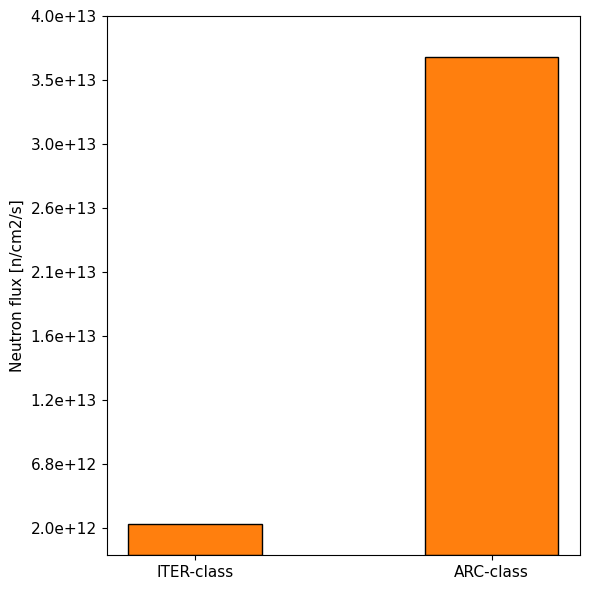

In [8]:
x = ['ITER-class', 'ARC-class']
y = [iter_flux, arc_flux]

fig, ax = plt.subplots(figsize=(6, 6))
yticks = np.linspace(2e12, 4e13, 9)
ax.bar(x, y, width=.45, color='tab:orange', edgecolor='k')
ax.set_ylabel('Neutron flux [n/cm2/s]', fontsize=11)
ax.set_yticks(yticks)
ax.set_xticklabels(x, fontsize=11)
ax.set_yticklabels(["{:.1e}".format(i) for i in yticks], fontsize=11)
fig.tight_layout()
# plt.savefig('fluxes_barchart.png', dpi=600)
plt.show()

In [9]:
iter_gas_production = iter_sp.get_tally(id=3).get_pandas_dataframe()
arc_gas_production = arc_sp.get_tally(id=3).get_pandas_dataframe()

print(iter_gas_production)
print(arc_gas_production)

  mesh 2       nuclide     score     mean std. dev.
       x  y  z                                     
0      1  1  1   total    (n,Xp) 6.89e-11  1.40e-11
1      1  1  1   total    (n,Xd) 5.53e-12  1.68e-12
2      1  1  1   total    (n,Xt) 4.09e-12  1.80e-13
3      1  1  1   total  (n,X3He) 5.09e-19  1.63e-19
4      1  1  1   total    (n,Xa) 5.00e-08  1.10e-09
  mesh 2       nuclide     score     mean std. dev.
       x  y  z                                     
0      1  1  1   total    (n,Xp) 2.05e-08  1.67e-09
1      1  1  1   total    (n,Xd) 2.23e-10  3.26e-11
2      1  1  1   total    (n,Xt) 2.14e-11  8.28e-13
3      1  1  1   total  (n,X3He) 1.76e-14  4.11e-15
4      1  1  1   total    (n,Xa) 1.36e-07  1.08e-09


In [10]:
nb3sn = tre.materials.nb3sn
ybco = tre.materials.ybco
lts_d = 0
for k in nb3sn.get_nuclide_atom_densities().keys():
    lts_d += nb3sn.get_nuclide_atom_densities()[k] * 1e24
hts_d = 0
for k in ybco.get_nuclide_atom_densities().keys():
    hts_d += ybco.get_nuclide_atom_densities()[k] * 1e24

print(lts_d, hts_d)

5.297396961689876e+22 7.4034663992406835e+22


/tmp/ipykernel_5875/3541850889.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x, fontsize=11)


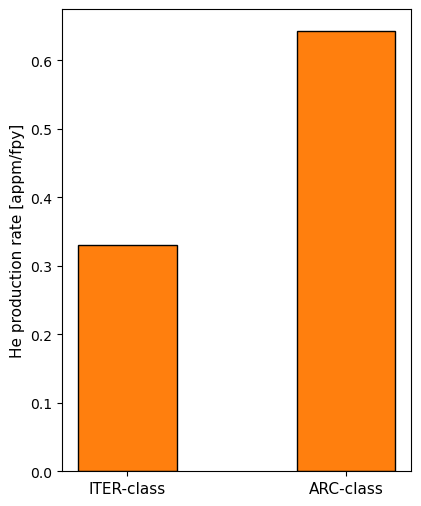

In [11]:
iter_he = float(iter_gas_production.loc[iter_gas_production['score'] == '(n,Xa)']['mean'])
iter_he *=  neutron_rate / iter_meshvol / lts_d * 1e6 * 3600*24*365
arc_he = float(arc_gas_production.loc[arc_gas_production['score'] == '(n,Xa)']['mean'])
arc_he *=  neutron_rate / iter_meshvol / hts_d * 1e6 * 3600*24*365

fig, ax = plt.subplots(figsize=(4.5, 6))
p1 = ax.bar(x, [iter_he, arc_he], width=.45, color='tab:orange', edgecolor='k')
ax.set_ylabel('He production rate [appm/fpy]', fontsize=11)
ax.set_xticklabels(x, fontsize=11)
# plt.savefig('he_transmutation.png', dpi=600, bbox_inches='tight')
plt.autoscale()
plt.show()

/tmp/ipykernel_5875/676619994.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x, fontsize=11)


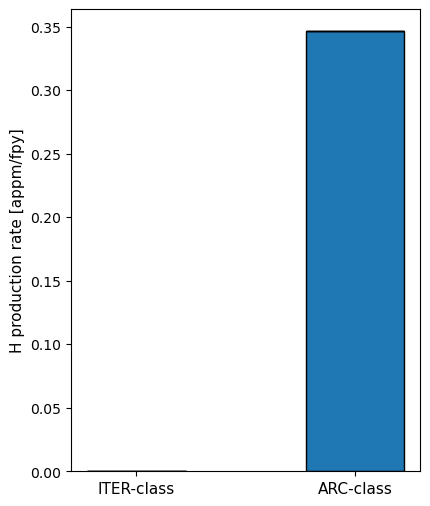

In [12]:
iter_p = np.array(float(iter_gas_production.loc[iter_gas_production['score'] == '(n,Xp)']['mean']))
iter_p *=  neutron_rate / iter_meshvol / lts_d * 1e6 * 3600*24*365
iter_d = np.array(float(iter_gas_production.loc[iter_gas_production['score'] == '(n,Xd)']['mean']))
iter_d *=  neutron_rate / iter_meshvol / lts_d * 1e6 * 3600*24*365
iter_t = np.array(float(iter_gas_production.loc[iter_gas_production['score'] == '(n,Xt)']['mean']))
iter_t *=  neutron_rate / iter_meshvol / lts_d * 1e6 * 3600*24*365

arc_p = np.array(float(arc_gas_production.loc[arc_gas_production['score'] == '(n,Xp)']['mean']))
arc_p *=  neutron_rate / arc_meshvol / hts_d * 1e6 * 3600*24*365
arc_d = np.array(float(iter_gas_production.loc[arc_gas_production['score'] == '(n,Xd)']['mean']))
arc_d *=  neutron_rate / arc_meshvol / hts_d * 1e6 * 3600*24*365
arc_t = np.array(float(iter_gas_production.loc[arc_gas_production['score'] == '(n,Xt)']['mean']))
arc_t *=  neutron_rate / arc_meshvol / hts_d * 1e6 * 3600*24*365

fig, ax = plt.subplots(figsize=(4.5, 6))
p1 = ax.bar(x, [iter_p, arc_p], width=.45, color='tab:blue', edgecolor='k')
p2 = ax.bar(x, [iter_d, arc_d], width=.45, bottom=[iter_p, arc_p], color='tab:green', edgecolor='k')
p3 = ax.bar(x, [iter_t, arc_t], width=.45, bottom=[iter_p+iter_d, arc_p+arc_d], color='tab:blue', edgecolor='k')
ax.set_ylabel('H production rate [appm/fpy]', fontsize=11)
ax.set_xticklabels(x, fontsize=11)
# plt.savefig('H_transmutation.png', dpi=600, bbox_inches='tight')
plt.show()